In [505]:
import numpy as np
import pandas as pd
import pandas_datareader.data as pdr
import matplotlib.pyplot as plt
import datetime
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, r2_score

In [506]:
# GPU setting

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#print(torch.cuda.get_device_name(0)) #Google colab = TESLA T4

In [507]:
 # Data load

df = pd.read_csv('경기도_clustered1.csv',encoding = 'cp949')

cluster = pd.read_csv('경기도_clustered1.csv',encoding = 'cp949',index_col = 0)
cluster

,수원시,성남시,의정부시,안양시,부천시,광명시,평택시,동두천시,안산시,고양시,...,안성시,김포시,화성시,광주시,양주시,여주시,포천시,의왕시,오산시,cluster
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,63.40000,67.80000,77.70000,60.50000,68.10000,53.00000,92.60000,92.60000,66.80000,69.50000,...,92.60000,71.10000,73.00000,82.40000,82.00000,102.80000,93.60000,59.70000,83.20000,1
2013-02-01,63.30000,67.20000,77.40000,60.20000,67.70000,52.90000,92.50000,90.90000,66.60000,69.00000,...,92.80000,70.90000,72.90000,82.00000,81.70000,102.80000,93.60000,59.10000,83.00000,1
2013-03-01,63.20000,66.90000,76.90000,60.00000,67.40000,52.60000,92.40000,90.10000,66.30000,68.60000,...,92.80000,70.80000,72.80000,81.90000,81.40000,102.70000,93.60000,58.70000,82.90000,1
2013-04-01,63.30000,67.10000,76.40000,59.80000,67.40000,52.60000,92.40000,90.00000,66.30000,68.10000,...,93.50000,70.70000,73.20000,82.30000,81.70000,102.70000,93.90000,58.60000,82.90000,1
2013-05-01,63.40000,67.50000,76.40000,59.60000,67.60000,52.90000,92.40000,89.80000,66.60000,68.10000,...,93.80000,71.00000,73.60000,82.30000,81.90000,103.60000,94.70000,58.80000,82.90000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-01,109.50000,104.80000,107.20000,111.70000,110.20000,107.30000,113.20000,107.70000,110.70000,107.60000,...,114.80000,105.30000,111.60000,107.90000,109.50000,106.60000,108.40000,112.90000,115.90000,0
2021-12-01,109.80000,105.10000,107.40000,112.00000,110.80000,107.40000,114.10000,107.50000,111.20000,108.00000,...,116.10000,105.60000,111.60000,108.40000,109.80000,107.20000,109.00000,113.00000,116.70000,0
2022-01-01,109.80000,105.10000,107.40000,111.80000,110.80000,107.30000,114.30000,107.50000,111.30000,108.10000,...,116.90000,105.60000,111.50000,108.70000,109.80000,107.10000,109.20000,113.00000,116.80000,0


In [508]:
data = pd.read_csv('경기도변수.csv')
feature = pd.read_csv('경기도변수.csv',index_col = 0)
data

,date,seoul,Avg_1,Avg_2,Avg_3,MMI,CPI,대출금리,전세가격지수 전국,전세가격지수 경기도,환율,M2,코스피,코스닥,건축허용면적,거래량 전국,거래량 경기
0,2013-01-01,73.50000,64.75625,93.90000,80.10000,102.86800,92.72800,5.78000,82.68933,76.00764,1089.00000,1841.10000,1961.90000,503.67000,8413721.00000,54632,13631
1,2013-02-01,73.20000,64.42500,93.66667,79.80000,90.00900,93.03800,5.66000,82.87118,76.10804,1083.00000,1857.10000,2026.50000,535.87000,7268443.00000,65640,14925
2,2013-03-01,73.10000,64.22500,93.55000,79.60000,101.38800,92.95200,5.54000,83.16272,76.37669,1111.00000,1862.40000,2004.90000,555.02000,10160177.00000,87563,17718
3,2013-04-01,73.20000,64.30000,93.76667,79.50000,101.29500,92.82300,5.42000,83.55404,76.85819,1101.00000,1867.70000,1964.00000,563.87000,9757932.00000,106498,22790
4,2013-05-01,73.40000,64.49375,94.11667,79.60000,102.31300,92.82300,5.24000,83.79708,77.09053,1129.70000,1870.30000,2001.05000,577.87000,10837979.00000,120393,25910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,2021-10-01,103.50000,107.45625,108.65000,108.80000,114.80000,103.35000,3.47000,102.45093,103.90395,1168.60000,3543.40000,2970.68000,992.33000,14689855.00000,119686,29187
106,2021-11-01,104.10000,108.45625,110.16667,109.80000,119.30000,103.87000,3.58000,102.91790,104.54323,1187.90000,3594.70000,2839.01000,965.63000,14483042.00000,111172,26593
107,2021-12-01,104.40000,108.79375,111.03333,110.20000,126.70000,104.04000,3.68000,103.17831,104.79809,1188.80000,3620.10000,2977.65000,1033.98000,19169150.00000,101766,25669
108,2022-01-01,104.40000,108.75000,111.38333,110.30000,115.10000,104.69000,3.75000,103.25089,104.79087,1205.50000,3634.30000,2663.34000,872.87000,13736304.00000,87825,20544


In [509]:
train = data.copy()

In [510]:
train.corr()

,seoul,Avg_1,Avg_2,Avg_3,MMI,CPI,대출금리,전세가격지수 전국,전세가격지수 경기도,환율,M2,코스피,코스닥,건축허용면적,거래량 전국,거래량 경기
seoul,1.00000,0.90937,0.22791,0.77387,0.65565,0.98536,-0.78876,0.82194,0.83350,0.51119,0.98395,0.71342,0.80426,0.12069,0.27725,0.46107
Avg_1,0.90937,1.00000,0.43014,0.95232,0.65904,0.91431,-0.73825,0.85927,0.86416,0.45403,0.95073,0.82543,0.85191,0.21349,0.14592,0.22341
Avg_2,0.22791,0.43014,1.00000,0.63663,0.26381,0.31619,-0.26385,0.62986,0.60502,0.12227,0.25843,0.40436,0.41053,0.46749,-0.12229,-0.11360
Avg_3,0.77387,0.95232,0.63663,1.00000,0.61770,0.80261,-0.59546,0.82992,0.82501,0.35248,0.82588,0.83377,0.80558,0.25581,-0.00010,0.04684
MMI,0.65565,0.65904,0.26381,0.61770,1.00000,0.64364,-0.50888,0.59033,0.59217,0.22583,0.66092,0.59047,0.57564,0.37032,0.31797,0.35594
CPI,0.98536,0.91431,0.31619,0.80261,0.64364,1.00000,-0.78866,0.86051,0.86782,0.47790,0.97765,0.73679,0.80020,0.13549,0.25272,0.43478
대출금리,-0.78876,-0.73825,-0.26385,-0.59546,-0.50888,-0.78866,1.00000,-0.88344,-0.89777,-0.55747,-0.82740,-0.57529,-0.73038,-0.41693,-0.54202,-0.61100
전세가격지수 전국,0.82194,0.85927,0.62986,0.82992,0.59033,0.86051,-0.88344,1.00000,0.99877,0.44409,0.85400,0.73851,0.83238,0.45508,0.31973,0.41120
전세가격지수 경기도,0.83350,0.86416,0.60502,0.82501,0.59217,0.86782,-0.89777,0.99877,1.00000,0.46612,0.86609,0.73232,0.83338,0.44888,0.33749,0.42914
환율,0.51119,0.45403,0.12227,0.35248,0.22583,0.47790,-0.55747,0.44409,0.46612,1.00000,0.52514,0.03280,0.22826,0.16604,0.12524,0.22564


In [511]:
# Training/Test ratio = 7:3

Train_ratio = 0.7

Test_ratio = 0.3

In [512]:
result =  pd.DataFrame(data=[0,0,0,0],
                             index = ['MAE','RMSE','MAPE', 'R2'],
                             columns=['test'])
predict =  pd.DataFrame(data=[0*14])

lag 변수 생성

In [513]:
df.set_index('date', inplace=True)
data.set_index('date', inplace=True)

In [514]:
lag_col= list(df.columns)


lag_amount = 3

for col in lag_col:
    for i in range(lag_amount):
        df['{0}_lag{1}'.format(col,i+1)] = df['{}'.format(col)].shift(i+1)
        
df.dropna(inplace=True)

In [515]:
df = df.iloc[:-3,:]
df

,수원시,성남시,의정부시,안양시,부천시,광명시,평택시,동두천시,안산시,고양시,...,포천시_lag3,의왕시_lag1,의왕시_lag2,의왕시_lag3,오산시_lag1,오산시_lag2,오산시_lag3,cluster_lag1,cluster_lag2,cluster_lag3
date,,,,,,,,,,,,,,,,,,,,,
2013-04-01,63.30000,67.10000,76.40000,59.80000,67.40000,52.60000,92.40000,90.00000,66.30000,68.10000,...,93.60000,58.70000,59.10000,59.70000,82.90000,83.00000,83.20000,1.00000,1.00000,1.00000
2013-05-01,63.40000,67.50000,76.40000,59.60000,67.60000,52.90000,92.40000,89.80000,66.60000,68.10000,...,93.60000,58.60000,58.70000,59.10000,82.90000,82.90000,83.00000,1.00000,1.00000,1.00000
2013-06-01,63.50000,67.90000,76.20000,59.50000,67.60000,53.00000,92.60000,89.60000,66.80000,68.00000,...,93.60000,58.80000,58.60000,58.70000,82.90000,82.90000,82.90000,1.00000,1.00000,1.00000
2013-07-01,63.40000,67.70000,75.50000,59.50000,67.50000,53.10000,92.50000,89.30000,66.70000,67.90000,...,93.90000,59.10000,58.80000,58.60000,82.40000,82.90000,82.90000,1.00000,1.00000,1.00000
2013-08-01,63.20000,67.40000,75.20000,59.40000,67.20000,52.90000,92.30000,89.00000,66.50000,67.90000,...,94.70000,58.70000,59.10000,58.80000,82.10000,82.40000,82.90000,1.00000,1.00000,1.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-01,104.70000,102.60000,103.80000,106.20000,104.50000,104.00000,106.20000,104.50000,105.00000,103.10000,...,97.90000,103.10000,100.00000,96.30000,103.50000,100.00000,96.00000,0.00000,0.00000,0.00000
2021-09-01,106.50000,103.60000,105.20000,108.30000,106.70000,105.50000,108.80000,106.40000,107.10000,105.00000,...,100.00000,106.40000,103.10000,100.00000,107.30000,103.50000,100.00000,0.00000,0.00000,0.00000
2021-10-01,108.40000,104.30000,106.50000,110.50000,108.70000,106.70000,111.70000,107.30000,109.30000,106.70000,...,101.60000,109.10000,106.40000,103.10000,110.70000,107.30000,103.50000,0.00000,0.00000,0.00000


In [516]:
lag_col= list(data.columns)


lag_amount = 3

for col in lag_col:
    for i in range(lag_amount):
        data['{0}_lag{1}'.format(col,i+1)] = data['{}'.format(col)].shift(i+1)
        
data.dropna(inplace=True)

In [517]:
data= data.iloc[:-2,:]
data

,seoul,Avg_1,Avg_2,Avg_3,MMI,CPI,대출금리,전세가격지수 전국,전세가격지수 경기도,환율,...,코스닥_lag3,건축허용면적_lag1,건축허용면적_lag2,건축허용면적_lag3,거래량 전국_lag1,거래량 전국_lag2,거래량 전국_lag3,거래량 경기_lag1,거래량 경기_lag2,거래량 경기_lag3
date,,,,,,,,,,,,,,,,,,,,,
2013-04-01,73.20000,64.30000,93.76667,79.50000,101.29500,92.82300,5.42000,83.55404,76.85819,1101.00000,...,503.67000,10160177.00000,7268443.00000,8413721.00000,87563.00000,65640.00000,54632.00000,17718.00000,14925.00000,13631.00000
2013-05-01,73.40000,64.49375,94.11667,79.60000,102.31300,92.82300,5.24000,83.79708,77.09053,1129.70000,...,535.87000,9757932.00000,10160177.00000,7268443.00000,106498.00000,87563.00000,65640.00000,22790.00000,17718.00000,14925.00000
2013-06-01,73.20000,64.55000,94.30000,79.50000,99.72200,92.71000,5.05000,83.97808,77.26569,1142.00000,...,555.02000,10837979.00000,9757932.00000,10160177.00000,120393.00000,106498.00000,87563.00000,25910.00000,22790.00000,17718.00000
2013-07-01,72.80000,64.36875,94.23333,79.10000,99.90700,92.90900,5.09000,84.23058,77.47430,1123.50000,...,563.87000,10007009.00000,10837979.00000,9757932.00000,160468.00000,120393.00000,106498.00000,33741.00000,25910.00000,22790.00000
2013-08-01,72.50000,64.17500,94.08333,78.80000,96.11500,93.23800,5.06000,84.58286,77.93904,1110.00000,...,577.87000,11233555.00000,10007009.00000,10837979.00000,74944.00000,160468.00000,120393.00000,16437.00000,33741.00000,25910.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-01,101.70000,104.06250,104.50000,104.70000,110.50000,102.75000,3.32000,101.22584,101.99146,1159.50000,...,981.78000,14591577.00000,16013705.00000,13891755.00000,140102.00000,144759.00000,154949.00000,39146.00000,38191.00000,42027.00000
2021-09-01,102.70000,105.82500,106.61667,106.90000,111.10000,103.17000,3.40000,101.82469,102.96483,1184.00000,...,1029.96000,13946424.00000,14591577.00000,16013705.00000,133495.00000,140102.00000,144759.00000,36154.00000,39146.00000,38191.00000
2021-10-01,103.50000,107.45625,108.65000,108.80000,114.80000,103.35000,3.47000,102.45093,103.90395,1168.60000,...,1031.14000,14652194.00000,13946424.00000,14591577.00000,122333.00000,133495.00000,140102.00000,33662.00000,36154.00000,39146.00000


In [544]:
for i in range(5):
    clust_n = int(cluster[cluster.columns[i]][-1])
    
    answer = []
    for num in range(11):
        if abs(train.corr()['Avg_{}'.format(clust_n+1)][num])>=0.7:
            answer.append(num)
    
    col =[]
    for j in  answer:
        col.append(data.columns[j])
    
    
    x = data[col].replace(',','')
    y = df.iloc[:,i:i+1]
    
       
    train_x = x.iloc[0:int(len(x)*Train_ratio),:]

    train_y = y.iloc[0:int(len(x)*Train_ratio),:]

    test_x = x.iloc[int(len(x)*Train_ratio):,:]

    test_y = y.iloc[int(len(x)*Train_ratio):,:]
    

    
    

    # Normalizing , 둘다 학습하여 성능비교할것

    minmax = MinMaxScaler()

    standard = StandardScaler()

    
    yscaler = minmax.fit(y.values.reshape(-1,1))
    train_x = minmax.fit_transform(train_x)

    train_y = minmax.fit_transform(train_y)

    test_x = minmax.fit_transform(test_x)

    test_y = minmax.fit_transform(test_y)





    # Numpy array상태로는 학습이 불가능하므로, Torch Variable 형태로 변경(data/grad/grad_fn)

    train_x_tensor = Variable(torch.Tensor(train_x))

    train_y_tensor = Variable(torch.Tensor(train_y))

    

    test_x_tensor = Variable(torch.Tensor(test_x))

    test_y_tensor = Variable(torch.Tensor(test_y))

    

    train_x_tensor_final = torch.reshape(train_x_tensor, (train_x_tensor.shape[0], 1, train_x_tensor.shape[1]))

    train_y_tensor_final = torch.reshape(train_y_tensor, (train_y_tensor.shape[0], 1, train_y_tensor.shape[1]))

    test_x_tensor_final = torch.reshape(test_x_tensor, (test_x_tensor.shape[0], 1, test_x_tensor.shape[1]))

    test_y_tensor_final = torch.reshape(test_y_tensor,(test_y_tensor.shape[0], 1, test_y_tensor.shape[1]) )

    


    ## LSTM network modeling

    class LSTM_Jun(nn.Module):

        def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length) : 

            super(LSTM_Jun, self).__init__()

            self.num_classes = num_classes

            self.num_layers = num_layers

            self.input_size = input_size

            self.hidden_size = hidden_size

            self.seq_length = seq_length

            self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, batch_first = True)

            self.layer_1 = nn.Linear(hidden_size, 256)

            self.layer_2 = nn.Linear(256,256)

            self.layer_3 = nn.Linear(256,128)

            self.layer_out = nn.Linear(128, num_classes)

            self.relu = nn.ReLU() #Activation Func



        def forward(self,x):

            h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) #Hidden State

            c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) #Internal Process States



            output, (hn, cn) = self.lstm(x, (h_0, c_0))



            hn = hn.view(-1, self.hidden_size) # Reshaping the data for starting LSTM network

            out = self.relu(hn) #pre-processing for first layer

            out = self.layer_1(out) # first layer

            out = self.relu(out) # activation func relu

            out = self.layer_2(out)

            out = self.relu(out)

            out = self.layer_3(out)

            out = self.relu(out)

            out = self.layer_out(out) #Output layer

            return out

 

    # Code Main

    num_epochs = 100000
    learning_rate = 0.005

    input_size = int(len(x.columns))

    hidden_size = 2 # number of features in hidden state

    num_layers = 1

    num_classes = int(len(y.columns))



    LSTM_Jun = LSTM_Jun(num_classes, input_size, hidden_size, num_layers, train_x_tensor_final.shape[1]).to(device)



    loss_function = torch.nn.MSELoss()

    optimizer = torch.optim.Adam(LSTM_Jun.parameters(), lr = learning_rate)

 

    for epoch in range(num_epochs) : 

        outputs = LSTM_Jun.forward(train_x_tensor_final.to(device))

        optimizer.zero_grad()

        loss = loss_function(outputs, train_y_tensor.to(device))

        loss.backward()

        optimizer.step() # improve from loss = back propagation

        if epoch % 100 == 0 :

            print("Epoch : %d, loss : %1.5f" % (epoch, loss.item()))
            

    # Estimated Value

    test_predict = LSTM_Jun(test_x_tensor_final.to(device)) #Forward Pass

    predict_data = test_predict.data.detach().cpu().numpy() #numpy conversion

    predict_data = minmax.inverse_transform(predict_data) #inverse normalization(Min/Max)
    
    y_pred = predict_data[:,0]

    # Real Value

    real_data = test_y_tensor.data.numpy() # Real value

    real_data = minmax.inverse_transform(real_data) #inverse normalization 
    
    y_test = real_data[:,0]

    
    MAE = mean_absolute_error(y_test, y_pred)
    RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
    R2 = r2_score(y_test, y_pred)
    MAPE= np.mean(np.abs((y_test - y_pred) / y_test))
    pd.options.display.float_format = '{:.5f}'.format
    
    label = df.columns[i]
    Result = pd.DataFrame(data=[MAE,RMSE, MAPE,R2],
                         index = ['MAE','RMSE','MAPE','R2'],
                         columns=[label])
        
    

    result = pd.concat([result,Result],axis = 1)

    DAYS_TO_PREDICT = 14
    with torch.no_grad():
        test_seq = test_x_tensor_final[:-1]
        preds = []
        for i in range(DAYS_TO_PREDICT):
            y_test_pred = LSTM_Jun(test_seq)[-1:,0]
            pred = torch.flatten(y_test_pred).item()
            preds.append(pred)
            new_seq = test_seq.numpy().flatten()
            new_seq = np.append(new_seq, [pred])
            new_seq = new_seq[1:]
            test_seq = torch.as_tensor(new_seq).view(test_x_tensor_final[:-1].shape[0],1,test_x_tensor_final[:-1].shape[2]).float()

    # Prediction value 스케일링 역변환
    pred_values = yscaler.inverse_transform(np.array(preds).reshape(-1,1))
    pred_values

    # 예측값 반올림
    import math

    pred_values_ceiled = list(pred_values.flatten())
    predicted_cases=pred_values_ceiled
    predicted_cases

    predicted_index = pd.date_range(
      start=data.index[-1],
      periods=DAYS_TO_PREDICT + 1, freq = 'MS',
      closed='right'
    )

    predicted_index = pd.to_datetime(predicted_index, format='%Y%m%d')

    predicted_cases_i = pd.DataFrame(
      data=predicted_cases,
      index=predicted_index
    )
    
    if not i :
        predict = predicted_cases_i
    else:
        predict =pd.concat([predict,predicted_cases_i],axis = 1)

    preds_i = pd.DataFrame(predicted_cases_i)
    feature.index = pd.to_datetime(feature.index)

    y_i = pd.DataFrame(data =df[df.columns[i]].values,index = df.index)
    y_i.index.name = ''


Epoch : 0, loss : 0.45869
Epoch : 100, loss : 0.00372
Epoch : 200, loss : 0.00060
Epoch : 300, loss : 0.00037
Epoch : 400, loss : 0.00043
Epoch : 500, loss : 0.00020
Epoch : 600, loss : 0.00027
Epoch : 700, loss : 0.00017
Epoch : 800, loss : 0.00013
Epoch : 900, loss : 0.00049


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexes\base.py:2955: RuntimeWarning: '<' not supported between instances of 'Timestamp' and 'int', sort order is undefined for incomparable objects
  return left.union(right, sort=sort)


Epoch : 0, loss : 0.15361
Epoch : 100, loss : 0.00102
Epoch : 200, loss : 0.00064
Epoch : 300, loss : 0.00062
Epoch : 400, loss : 0.00048
Epoch : 500, loss : 0.00044
Epoch : 600, loss : 0.00044
Epoch : 700, loss : 0.00039
Epoch : 800, loss : 0.00062
Epoch : 900, loss : 0.00063


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexes\base.py:2955: RuntimeWarning: '<' not supported between instances of 'Timestamp' and 'int', sort order is undefined for incomparable objects
  return left.union(right, sort=sort)


Epoch : 0, loss : 0.57634
Epoch : 100, loss : 0.00131
Epoch : 200, loss : 0.00124
Epoch : 300, loss : 0.00128
Epoch : 400, loss : 0.00035
Epoch : 500, loss : 0.00028
Epoch : 600, loss : 0.00014
Epoch : 700, loss : 0.00019
Epoch : 800, loss : 0.00015
Epoch : 900, loss : 0.00022


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexes\base.py:2955: RuntimeWarning: '<' not supported between instances of 'Timestamp' and 'int', sort order is undefined for incomparable objects
  return left.union(right, sort=sort)


Epoch : 0, loss : 0.27753
Epoch : 100, loss : 0.00194
Epoch : 200, loss : 0.00069
Epoch : 300, loss : 0.00035
Epoch : 400, loss : 0.00022
Epoch : 500, loss : 0.00018
Epoch : 600, loss : 0.00015
Epoch : 700, loss : 0.00017
Epoch : 800, loss : 0.00016
Epoch : 900, loss : 0.00012


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexes\base.py:2955: RuntimeWarning: '<' not supported between instances of 'Timestamp' and 'int', sort order is undefined for incomparable objects
  return left.union(right, sort=sort)


Epoch : 0, loss : 0.26896
Epoch : 100, loss : 0.00128
Epoch : 200, loss : 0.00038
Epoch : 300, loss : 0.00016
Epoch : 400, loss : 0.00010
Epoch : 500, loss : 0.00010
Epoch : 600, loss : 0.00037
Epoch : 700, loss : 0.00011
Epoch : 800, loss : 0.00009
Epoch : 900, loss : 0.00035


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexes\base.py:2955: RuntimeWarning: '<' not supported between instances of 'Timestamp' and 'int', sort order is undefined for incomparable objects
  return left.union(right, sort=sort)


In [545]:
result

,test,수원시,성남시,의정부시,의정부시,수원시,성남시,의정부시,안양시,부천시,수원시,성남시,의정부시,안양시,부천시,수원시,성남시,의정부시,안양시,부천시
MAE,0,4.57100,3.48725,1.05680,1.98366,3.00415,3.59220,3.69986,12.83681,2.45618,3.14578,2.41666,2.44903,2.11577,3.15619,2.83830,3.00029,2.79080,6.39460,0.72039
RMSE,0,5.63490,4.31395,1.19148,2.55614,4.13460,4.62844,3.91583,14.08839,2.87639,4.29838,3.72880,2.94449,2.92958,3.48499,4.17264,4.03592,2.96428,7.89153,1.00541
MAPE,0,0.05220,0.03680,0.01151,0.02293,0.03372,0.03787,0.04238,0.15437,0.02715,0.03507,0.02514,0.02710,0.02398,0.03561,0.03252,0.03162,0.03191,0.07456,0.00776
R2,0,0.76905,0.64277,0.98234,0.91870,0.87566,0.58879,0.80920,-0.24246,0.91839,0.86561,0.73311,0.89212,0.94628,0.88020,0.87336,0.68734,0.89066,0.61016,0.99003


In [546]:
predict

,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-01 00:00:00,NaN,108.82576,107.55121,111.08159,106.21004,109.69472,92.66113,105.63154,109.41150,105.16783,108.35532,114.11609,107.03345,109.76337,104.28388,108.85211,108.80101,109.64672
2022-02-01 00:00:00,NaN,110.39688,106.60238,122.06484,107.82449,110.76155,92.66113,107.04684,109.77180,102.47569,108.44595,110.85681,109.76147,109.76337,91.75456,108.71252,106.16988,115.13645
2022-03-01 00:00:00,NaN,113.45842,97.67817,121.65753,106.24644,111.06132,92.66113,105.14218,87.40175,97.40917,108.48722,114.94633,112.82399,109.76337,89.65675,109.31190,110.95248,129.96382
2022-04-01 00:00:00,NaN,105.45675,92.20177,118.25170,102.23748,111.39452,92.66113,105.51385,83.97321,89.95359,108.54886,99.65695,104.06760,109.76337,89.16495,109.07689,97.47370,104.10020
2022-05-01 00:00:00,NaN,104.62577,89.53903,115.51064,95.64174,111.76307,92.66113,99.11323,97.39591,91.12415,108.41765,100.87134,97.63345,109.76337,86.27274,109.32540,98.39629,103.50199
2022-06-01 00:00:00,NaN,107.74044,92.28842,124.13307,106.43349,112.43603,92.66113,105.20646,75.76172,104.80748,108.66491,109.69761,106.66687,109.76337,89.35922,109.40550,101.23766,112.60784
2022-07-01 00:00:00,NaN,109.82135,99.57293,125.67981,106.39623,112.02560,92.66113,105.18523,77.57510,102.76682,108.59568,111.14019,112.82399,109.76337,89.11494,109.65671,104.40581,113.90054
2022-08-01 00:00:00,NaN,110.80340,97.78598,123.82193,110.71964,112.71966,92.66113,105.18841,84.28314,100.60777,108.86006,115.40146,104.40830,109.76337,89.03821,109.78687,106.48554,106.82195
2022-09-01 00:00:00,NaN,110.91008,95.26696,125.11069,109.47635,113.28821,92.66113,103.77622,74.31564,99.35955,108.91959,116.47143,102.96361,109.76337,89.01160,109.84762,105.26345,106.09165


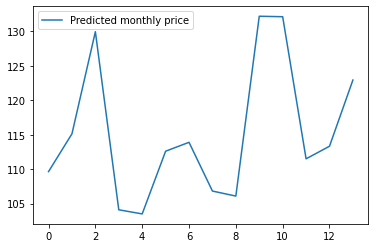

In [547]:
plt.plot(predicted_cases, label='Predicted monthly price')
plt.legend();

In [549]:
plt.figure(figsize=(25,5))
plt.plot(y_3,label='real')
plt.plot(preds_3, label='predict')
plt.xticks(rotation=90)


plt.legend()

NameError: name 'y_3' is not defined

<Figure size 1800x360 with 0 Axes>